# IPC Subclass Patent Count Analysis

This notebook provides a comprehensive analysis of patent counts across all ~646 IPC (International Patent Classification) subclasses using the PATSTAT database.

## Overview

- **Goal**: Count patents for all IPC subclasses (4-character codes like A61K, B66B, etc.)
- **Data Source**: PATSTAT Global database via EPO TIP Data services
- **Advantage**: No 10,000 result limit (unlike OPS API)
- **Output**: Complete statistics with granted patents, families, and time ranges

## Key PATSTAT Tables Used

- **TLS209_APPLN_IPC**: IPC classification assignments
- **TLS201_APPLN**: Application details (filing dates, granted status, etc.)

## Prerequisites

Ensure you have access to the EPO TIP Data PATSTAT environment and required Python packages.

## 1. Setup and Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# PATSTAT imports
from epo.tipdata.patstat import PatstatClient
from epo.tipdata.patstat.database.models import TLS201_APPLN, TLS209_APPLN_IPC
from sqlalchemy import func

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now()}")

Libraries imported successfully!
Analysis started at: 2025-06-09 08:43:18.792252


## 2. Database Connection

In [2]:
# Initialize PATSTAT client
# Use 'TEST' for quick testing (limited data) or 'PROD' for complete analysis
environment = 'PROD'  # Change 'TEST' to 'PROD' for full dataset

print(f"Connecting to PATSTAT {environment} environment...")
patstat = PatstatClient(env=environment)
db = patstat.orm()

print(f"✅ Connected to PATSTAT {environment} environment")
print(f"Database engine: {db.bind}")

Connecting to PATSTAT PROD environment...
✅ Connected to PATSTAT PROD environment
Database engine: Engine(bigquery+custom_dialect://p-epo-tip-prj-3a1f/p_epo_tip_euwe4_bqd_patstatb)


## 3. IPC Section Mapping

Define the 8 main IPC sections for context and analysis.

In [3]:
# IPC Section definitions
ipc_sections = {
    'A': 'Human Necessities',
    'B': 'Performing Operations; Transporting',
    'C': 'Chemistry; Metallurgy',
    'D': 'Textiles; Paper',
    'E': 'Fixed Constructions',
    'F': 'Mechanical Engineering; Lighting; Heating; Weapons; Blasting',
    'G': 'Physics',
    'H': 'Electricity'
}

def get_ipc_section_name(ipc_subclass):
    """Get full section name from IPC subclass."""
    if ipc_subclass and len(ipc_subclass) > 0:
        section = ipc_subclass[0]
        return ipc_sections.get(section, f"Section {section}")
    return "Unknown"

# Display IPC sections
print("IPC Classification Sections:")
print("=" * 50)
for section, description in ipc_sections.items():
    print(f"{section}: {description}")

IPC Classification Sections:
A: Human Necessities
B: Performing Operations; Transporting
C: Chemistry; Metallurgy
D: Textiles; Paper
E: Fixed Constructions
F: Mechanical Engineering; Lighting; Heating; Weapons; Blasting
G: Physics
H: Electricity


## 4. Comprehensive IPC Subclass Analysis

Execute the main query to count patents across all IPC subclasses.

In [4]:
print("Building comprehensive IPC subclass query...")

# Import case from sqlalchemy for proper syntax
from sqlalchemy import case, text

# Main query for IPC subclass analysis - BigQuery compatible
comprehensive_query = db.query(
    func.substr(TLS209_APPLN_IPC.ipc_class_symbol, 1, 4).label('ipc_subclass'),
    func.count(TLS201_APPLN.appln_id).label('total_patents'),
    func.sum(
        case(
            (TLS201_APPLN.granted == 'Y', 1),
            else_=0
        )
    ).label('granted_patents'),
    func.count(func.distinct(TLS201_APPLN.docdb_family_id)).label('unique_families'),
    func.min(TLS201_APPLN.earliest_filing_year).label('earliest_year'),
    func.max(TLS201_APPLN.appln_filing_year).label('latest_year'),
    func.avg(TLS201_APPLN.nb_citing_docdb_fam).label('avg_citations')
).join(
    TLS201_APPLN, TLS209_APPLN_IPC.appln_id == TLS201_APPLN.appln_id
).filter(
    TLS201_APPLN.appln_id < 900000000,  # Exclude artificial applications
    func.char_length(func.substr(TLS209_APPLN_IPC.ipc_class_symbol, 1, 4)) == 4,  # Valid subclasses - BigQuery compatible
    TLS209_APPLN_IPC.ipc_class_level == 'A'  # Full IPC classification
).group_by(
    text('ipc_subclass')  # Use the alias directly
).order_by(
    func.count(TLS201_APPLN.appln_id).desc()
)

print("Executing query... This may take several minutes for PROD environment.")
print("⏳ Please wait...")

Building comprehensive IPC subclass query...
Executing query... This may take several minutes for PROD environment.
⏳ Please wait...


In [5]:
# Execute the query and convert to DataFrame
start_time = datetime.now()

try:
    ipc_analysis_df = patstat.df(comprehensive_query)
    end_time = datetime.now()
    query_duration = (end_time - start_time).total_seconds()
    
    print(f"✅ Query completed successfully!")
    print(f"⏱️ Query execution time: {query_duration:.2f} seconds")
    print(f"📊 Total IPC subclasses found: {len(ipc_analysis_df)}")
    
except Exception as e:
    print(f"❌ Query failed: {e}")
    print("Troubleshooting tips:")
    print("- Check database connection")
    print("- Verify PATSTAT access permissions")
    print("- Try using TEST environment first")

✅ Query completed successfully!
⏱️ Query execution time: 0.65 seconds
📊 Total IPC subclasses found: 656


## 5. Data Processing and Enhancement

In [6]:
# Add additional columns for analysis
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    # Add IPC section information
    ipc_analysis_df['ipc_section'] = ipc_analysis_df['ipc_subclass'].str[0]
    ipc_analysis_df['ipc_section_name'] = ipc_analysis_df['ipc_subclass'].apply(get_ipc_section_name)
    
    # Calculate grant rate
    ipc_analysis_df['grant_rate'] = (
        ipc_analysis_df['granted_patents'] / ipc_analysis_df['total_patents'] * 100
    ).round(2)
    
    # Calculate time span
    ipc_analysis_df['time_span'] = (
        ipc_analysis_df['latest_year'] - ipc_analysis_df['earliest_year']
    )
    
    # Handle missing citation data
    ipc_analysis_df['avg_citations'] = ipc_analysis_df['avg_citations'].fillna(0).round(2)
    
    print("✅ Data processing completed")
    print(f"📈 Dataset shape: {ipc_analysis_df.shape}")
    print(f"🔢 Total patents covered: {ipc_analysis_df['total_patents'].sum():,}")
else:
    print("❌ No data available for processing")

✅ Data processing completed
📈 Dataset shape: (656, 11)
🔢 Total patents covered: 351,091,219


## 6. Results Overview

In [28]:
# Display basic statistics
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    print("🏆 TOP 10 IPC SUBCLASSES BY PATENT COUNT")
    print("=" * 60)
    
    top_10 = ipc_analysis_df.head(10)[[
        'ipc_subclass', 'ipc_section_name', 'total_patents', 
        'granted_patents', 'grant_rate'
    ]]
    
    for idx, row in top_10.iterrows():
        print(f"{row['ipc_subclass']:4} | {row['ipc_section_name'][:25]:25} | "
              f"{row['total_patents']:8,} patents | "
              f"{row['granted_patents']:8,} granted ({row['grant_rate']:5.1f}%)")
    
    print("\n📊 SUMMARY STATISTICS")
    print("=" * 40)
    print(f"Total IPC subclasses analyzed: {len(ipc_analysis_df):,}")
    print(f"Total patents in dataset: {ipc_analysis_df['total_patents'].sum():,}")
    print(f"Total granted patents: {ipc_analysis_df['granted_patents'].sum():,}")
    print(f"Total unique families: {ipc_analysis_df['unique_families'].sum():,}")
    print(f"Average grant rate: {ipc_analysis_df['grant_rate'].mean():.1f}%")
    
else:
    print("❌ No results to display")

🏆 TOP 10 IPC SUBCLASSES BY PATENT COUNT
A61K | Human Necessities         | 16,083,074 patents | 7,966,039 granted ( 49.5%)
G06F | Physics                   | 10,412,010 patents | 5,589,802 granted ( 53.7%)
H01L | Electricity               | 9,471,825 patents | 5,556,852 granted ( 58.7%)
A61P | Human Necessities         | 8,247,430 patents | 3,821,222 granted ( 46.3%)
C07D | Chemistry; Metallurgy     | 7,405,343 patents | 4,238,182 granted ( 57.2%)
H04N | Electricity               | 6,491,533 patents | 3,763,108 granted ( 58.0%)
G01N | Physics                   | 5,794,385 patents | 3,401,386 granted ( 58.7%)
C07C | Chemistry; Metallurgy     | 5,468,323 patents | 3,458,852 granted ( 63.2%)
H04L | Electricity               | 4,753,867 patents | 2,860,973 granted ( 60.2%)
H01M | Electricity               | 4,637,919 patents | 2,589,996 granted ( 55.8%)

📊 SUMMARY STATISTICS
Total IPC subclasses analyzed: 656
Total patents in dataset: 351,091,219
Total granted patents: 212,567,892
Total un

In [29]:
# Display the complete dataset
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    print("📋 COMPLETE IPC SUBCLASS ANALYSIS RESULTS")
    print("=" * 80)
    
    # Reorder columns for better readability
    display_columns = [
        'ipc_subclass', 'ipc_section', 'ipc_section_name',
        'total_patents', 'granted_patents', 'grant_rate',
        'unique_families', 'earliest_year', 'latest_year', 
        'time_span', 'avg_citations'
    ]
    
    display_df = ipc_analysis_df[display_columns]
    
    # Show all results
    with pd.option_context('display.max_rows', None):
        display(display_df)
    
    print(f"\n✅ Showing all {len(display_df)} IPC subclasses")

📋 COMPLETE IPC SUBCLASS ANALYSIS RESULTS


,ipc_subclass,ipc_section,ipc_section_name,total_patents,granted_patents,grant_rate,unique_families,earliest_year,latest_year,time_span,avg_citations
0,A61K,A,Human Necessities,16083074,7966039,49.53,1648466,1889,9999,8110,26.67
1,G06F,G,Physics,10412010,5589802,53.69,3790886,1894,9999,8105,23.49
2,H01L,H,Electricity,9471825,5556852,58.67,2268677,1900,9999,8099,18.40
3,A61P,A,Human Necessities,8247430,3821222,46.33,1065249,1926,9999,8073,27.94
4,C07D,C,Chemistry; Metallurgy,7405343,4238182,57.23,628830,1882,9999,8117,27.62
5,H04N,H,Electricity,6491533,3763108,57.97,1654933,1819,9999,8180,31.70
6,G01N,G,Physics,5794385,3401386,58.70,2135604,1899,9999,8100,16.59
7,C07C,C,Chemistry; Metallurgy,5468323,3458852,63.25,633304,1882,9999,8117,16.33
8,H04L,H,Electricity,4753867,2860973,60.18,1517151,1884,9999,8115,28.24
9,H01M,H,Electricity,4637919,2589996,55.84,908450,1884,9999,8115,11.97



✅ Showing all 656 IPC subclasses


## 7. Analysis by IPC Section

In [30]:
# Aggregate statistics by IPC section
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    section_analysis = ipc_analysis_df.groupby(['ipc_section', 'ipc_section_name']).agg({
        'ipc_subclass': 'count',
        'total_patents': 'sum',
        'granted_patents': 'sum',
        'unique_families': 'sum',
        'grant_rate': 'mean',
        'avg_citations': 'mean'
    }).round(2)
    
    section_analysis.columns = [
        'subclasses_count', 'total_patents', 'granted_patents', 
        'unique_families', 'avg_grant_rate', 'avg_citations'
    ]
    
    section_analysis = section_analysis.sort_values('total_patents', ascending=False)
    
    print("🏗️ IPC SECTION ANALYSIS")
    print("=" * 80)
    display(section_analysis)
    
    print("\n📋 SECTION RANKINGS BY PATENT COUNT:")
    for idx, (section_info, row) in enumerate(section_analysis.iterrows(), 1):
        section, name = section_info
        print(f"{idx}. Section {section} ({name}): {row['total_patents']:,} patents")

🏗️ IPC SECTION ANALYSIS


,,subclasses_count,total_patents,granted_patents,unique_families,avg_grant_rate,avg_citations
ipc_section,ipc_section_name,,,,,,
B,Performing Operations; Transporting,170,68618663,45889560,28756264,66.47,7.80
A,Human Necessities,84,60280100,33701833,17457394,63.10,10.96
H,Electricity,54,59337950,35790412,19145689,61.38,14.89
G,Physics,87,56179111,31317754,23427274,57.81,13.05
C,Chemistry; Metallurgy,91,55734981,31774072,12926307,61.24,13.75
F,Mechanical Engineering; Lighting; Heating; Weapons; Blasting,100,32205818,21541633,14055747,65.79,7.34
E,Fixed Constructions,31,12913604,8987287,6657249,69.38,4.79
D,Textiles; Paper,39,5820992,3565341,2018548,65.28,7.81



📋 SECTION RANKINGS BY PATENT COUNT:
1. Section B (Performing Operations; Transporting): 68,618,663.0 patents
2. Section A (Human Necessities): 60,280,100.0 patents
3. Section H (Electricity): 59,337,950.0 patents
4. Section G (Physics): 56,179,111.0 patents
5. Section C (Chemistry; Metallurgy): 55,734,981.0 patents
6. Section F (Mechanical Engineering; Lighting; Heating; Weapons; Blasting): 32,205,818.0 patents
7. Section E (Fixed Constructions): 12,913,604.0 patents
8. Section D (Textiles; Paper): 5,820,992.0 patents


## 8. Data Export

In [38]:
# Export results to CSV files
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Export detailed IPC subclass analysis
    detailed_filename = f"./output/ipc_subclass_analysis_detailed_{timestamp}.csv"
    ipc_analysis_df.to_csv(detailed_filename, index=False)
    print(f"✅ Detailed analysis exported to: {detailed_filename}")
    
    # Export section summary
    if 'section_analysis' in locals():
        section_filename = f"./output/ipc_section_summary_{timestamp}.csv"
        section_analysis.to_csv(section_filename)
        print(f"✅ Section summary exported to: {section_filename}")
    
    # Create a simple summary for quick reference
    summary_df = ipc_analysis_df[[
        'ipc_subclass', 'total_patents', 'granted_patents', 'grant_rate'
    ]].copy()
    
    summary_filename = f"./output/ipc_subclass_summary_{timestamp}.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"✅ Quick summary exported to: {summary_filename}")
    
    print(f"\n📁 All files saved in: {os.getcwd()}")
else:
    print("❌ No data available for export")

✅ Detailed analysis exported to: ./output/ipc_subclass_analysis_detailed_20250608_220603.csv
✅ Section summary exported to: ./output/ipc_section_summary_20250608_220603.csv
✅ Quick summary exported to: ./output/ipc_subclass_summary_20250608_220603.csv

📁 All files saved in: /home/jovyan/mtc-patent-analytics/ipc-patstat


## 9. Visualization (Optional)

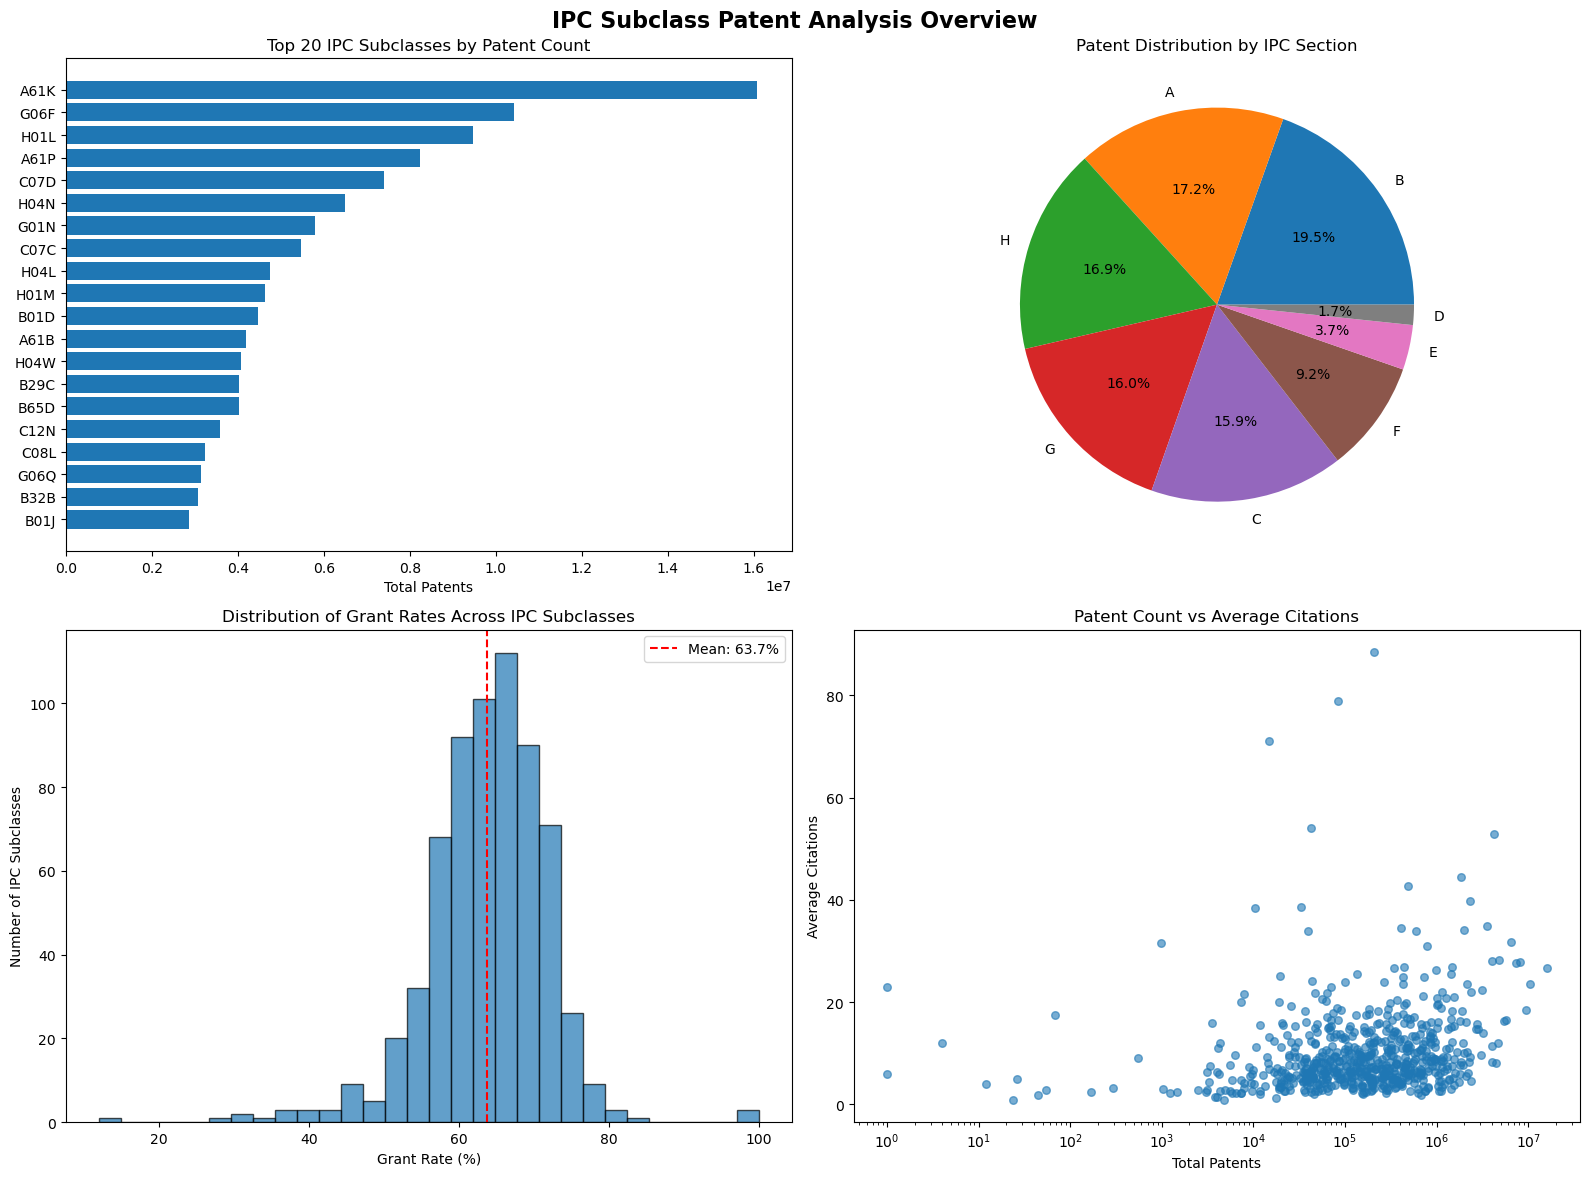

📊 Visualization saved as: ./output/ipc_analysis_overview_20250608_220603.png


In [39]:
# Create visualizations if data is available
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('IPC Subclass Patent Analysis Overview', fontsize=16, fontweight='bold')
    
    # 1. Top 20 IPC subclasses by patent count
    top_20 = ipc_analysis_df.head(20)
    axes[0, 0].barh(range(len(top_20)), top_20['total_patents'])
    axes[0, 0].set_yticks(range(len(top_20)))
    axes[0, 0].set_yticklabels(top_20['ipc_subclass'])
    axes[0, 0].set_xlabel('Total Patents')
    axes[0, 0].set_title('Top 20 IPC Subclasses by Patent Count')
    axes[0, 0].invert_yaxis()
    
    # 2. Patent distribution by IPC section
    if 'section_analysis' in locals():
        section_data = section_analysis.reset_index()
        axes[0, 1].pie(section_data['total_patents'], 
                      labels=section_data['ipc_section'], 
                      autopct='%1.1f%%')
        axes[0, 1].set_title('Patent Distribution by IPC Section')
    
    # 3. Grant rate distribution
    axes[1, 0].hist(ipc_analysis_df['grant_rate'], bins=30, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Grant Rate (%)')
    axes[1, 0].set_ylabel('Number of IPC Subclasses')
    axes[1, 0].set_title('Distribution of Grant Rates Across IPC Subclasses')
    axes[1, 0].axvline(ipc_analysis_df['grant_rate'].mean(), 
                      color='red', linestyle='--', 
                      label=f'Mean: {ipc_analysis_df["grant_rate"].mean():.1f}%')
    axes[1, 0].legend()
    
    # 4. Patent count vs Citations scatter plot
    scatter = axes[1, 1].scatter(ipc_analysis_df['total_patents'], 
                                ipc_analysis_df['avg_citations'],
                                alpha=0.6, s=30)
    axes[1, 1].set_xlabel('Total Patents')
    axes[1, 1].set_ylabel('Average Citations')
    axes[1, 1].set_title('Patent Count vs Average Citations')
    axes[1, 1].set_xscale('log')
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"./output/ipc_analysis_overview_{timestamp}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualization saved as: {plot_filename}")
else:
    print("❌ No data available for visualization")

## 11. Analysis Summary and Recommendations

In [40]:
# Final summary and recommendations
if 'ipc_analysis_df' in locals() and not ipc_analysis_df.empty:
    
    print("📊 FINAL ANALYSIS SUMMARY")
    print("=" * 60)
    
    total_subclasses = len(ipc_analysis_df)
    total_patents = ipc_analysis_df['total_patents'].sum()
    avg_patents_per_subclass = total_patents / total_subclasses
    
    print(f"📈 Dataset Overview:")
    print(f"   • Total IPC subclasses analyzed: {total_subclasses:,}")
    print(f"   • Total patents in dataset: {total_patents:,}")
    print(f"   • Average patents per subclass: {avg_patents_per_subclass:,.0f}")
    print(f"   • Environment used: {environment}")
    
    # Find the most and least active sections
    if 'section_analysis' in locals():
        most_active = section_analysis.index[0]
        least_active = section_analysis.index[-1]
        
        print(f"\n🏆 Most active section: {most_active[0]} - {most_active[1]}")
        print(f"   • {section_analysis.loc[most_active, 'total_patents']:,} patents")
        print(f"   • {section_analysis.loc[most_active, 'subclasses_count']} subclasses")
        
        print(f"\n🔻 Least active section: {least_active[0]} - {least_active[1]}")
        print(f"   • {section_analysis.loc[least_active, 'total_patents']:,} patents")
        print(f"   • {section_analysis.loc[least_active, 'subclasses_count']} subclasses")
        
    if environment == 'TEST':
        print(f"\n⚠️  NOTE: This analysis used TEST environment (limited data)")
        print(f"   For complete results, re-run with environment = 'PROD'")
    
    print(f"\n✅ Analysis completed successfully at {datetime.now()}")
    
else:
    print("❌ Analysis could not be completed due to data issues")
    print("   Check database connection and try again")

📊 FINAL ANALYSIS SUMMARY
📈 Dataset Overview:
   • Total IPC subclasses analyzed: 656
   • Total patents in dataset: 351,091,219
   • Average patents per subclass: 535,200
   • Environment used: PROD

🏆 Most active section: B - Performing Operations; Transporting
   • 68,618,663 patents
   • 170 subclasses

🔻 Least active section: D - Textiles; Paper
   • 5,820,992 patents
   • 39 subclasses

✅ Analysis completed successfully at 2025-06-08 22:06:14.991859


## 12. Next Steps

This analysis provides a foundation for further patent landscape research:

### Possible Extensions:

1. **Temporal Analysis**: Track IPC subclass trends over time
2. **Authority Analysis**: Compare patent activity by filing authority (EP, US, CN, etc.)
3. **Technology Mapping**: Connect IPC codes to technology fields using TLS901 table
4. **Citation Analysis**: Identify high-impact technology areas
5. **Company Analysis**: Link IPC data to applicant information

### Code Templates:

```python
# Example: Temporal analysis
temporal_query = db.query(
    TLS201_APPLN.appln_filing_year,
    func.substr(TLS209_APPLN_IPC.ipc_class_symbol, 1, 4).label('ipc_subclass'),
    func.count(TLS201_APPLN.appln_id).label('patents_per_year')
).join(...).filter(...).group_by(...)

# Example: Authority breakdown
authority_query = db.query(
    TLS201_APPLN.appln_auth,
    func.substr(TLS209_APPLN_IPC.ipc_class_symbol, 1, 4).label('ipc_subclass'),
    func.count(TLS201_APPLN.appln_id).label('patent_count')
).join(...).filter(...).group_by(...)
```

### Performance Tips:

- Use TEST environment for development and testing
- Add date filters to limit query scope when needed
- Consider pagination for very large result sets
- Cache results for repeated analysis